# Experimental Evaluation

MIFE scheme, we used ElGamal as the public-key encryption scheme

This notebook was runned with a HP Laptop 14s-dq1xxx with a 1GHz Intel Core i5 and 8GB RAM running Windows 10, 64 bit and Python 3.10 using `PyCryptoDome` and `numpy`

We first begin by generating some 1024 bit $G, P$ parameters that will be recycled for the whole experiment, since it is the most time consuming operation

In [1]:
from util import generate_gp

LOAD_GP = True

if LOAD_GP: 
    # loading the generated values
    with open('gp.txt', 'r') as f:
        G = int(f.readline().split('=')[1])
        P = int(f.readline().split('=')[1])
else:
    G, P = generate_gp(nbits=1024, num_processes=8)
    print("G =", G)
    print("P =", P) 
    # saving the generated values
    with open('gp.txt', 'w') as f:
        f.write("G = " + str(G) + "\n")
        f.write("P = " + str(P) + "\n")

After this we proceed to show an initial representation of the tree, and the following operations

1. **Tree generation and population**: The tree nodes are initialized depending on the $N$ value and a dataset is added
2. **Noise addition**: Noise is added to each node
3. **Encryption**: Each node is encypted. Note that the result of *ElGamal* encryption gives two large values of which only the first two digits are represented in the tree

Num_leaves: 16, Num_nodes: 31


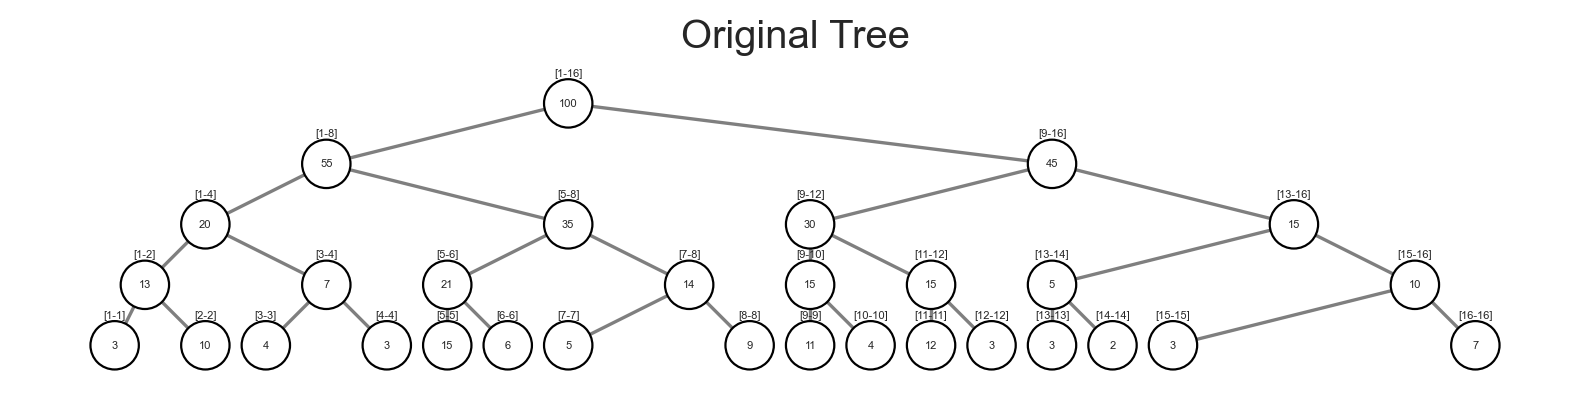

Query [1 - 5]: 35


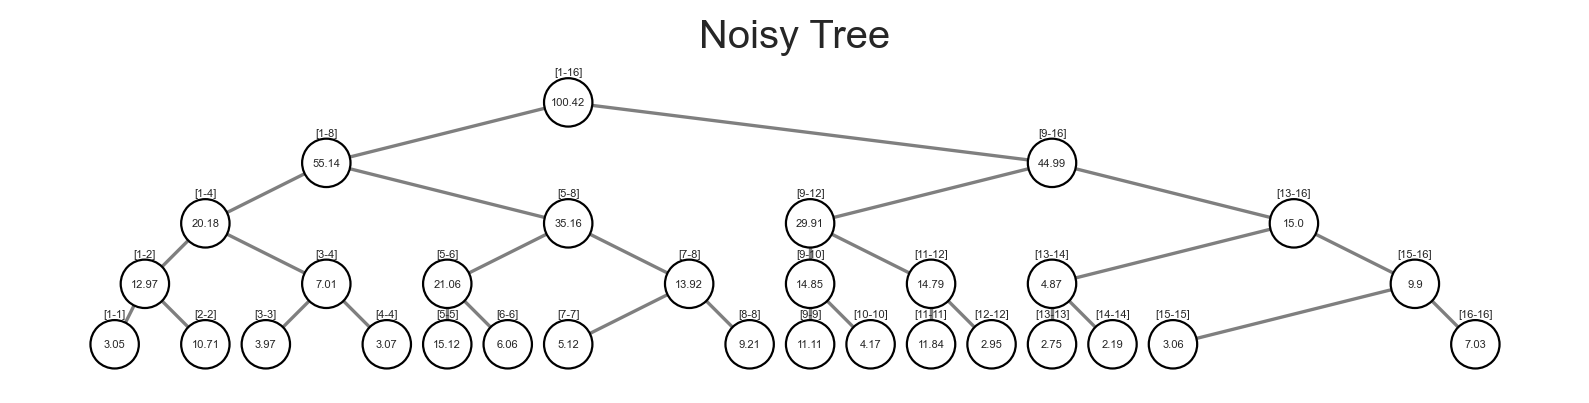

Query [1 - 5]: 35.30046355645504


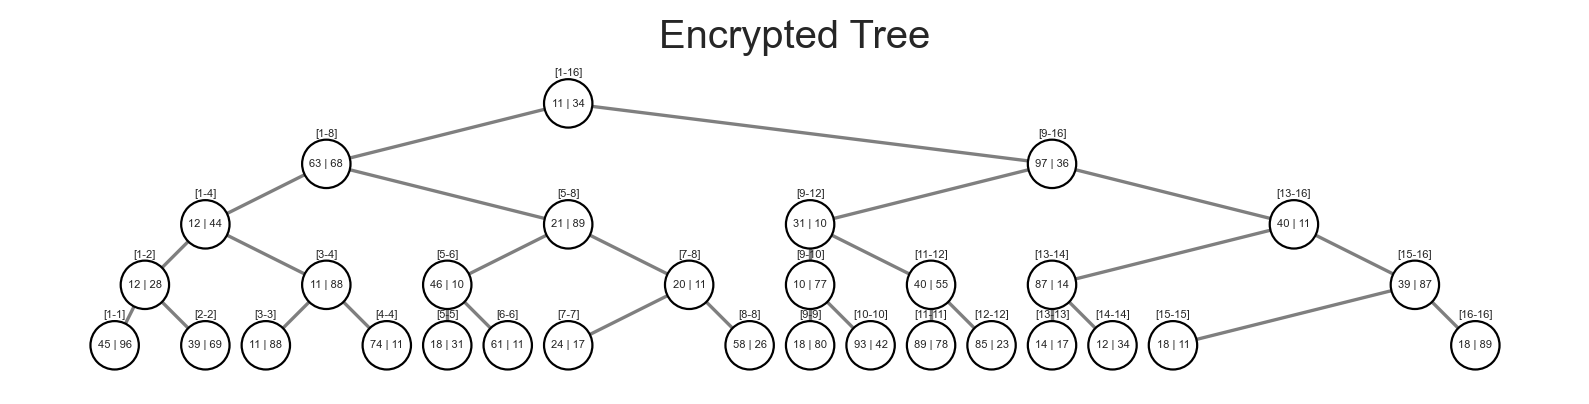

Query [1 - 5]: 35
{'generateAndPopulate': 0.000611600000411272, 'generateKeys': 0.6069549999956507, 'addNoise': 8.81000014487654e-05, 'encrypt': 0.3701751232147217}


In [15]:
import random
import math
import numpy as np
from mife import MIFE, ElGamal
from util import *
from plm import PLM_H
from entities import BinaryRangeTree, Curator
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200


N = 4
DATASET_SIZE = 100

print(f"Num_leaves: {2**N}, Num_nodes: {2**(N+1)-1}")

x = np.random.randint(1, 2**N+1, DATASET_SIZE)
C = Curator(N, x, G=G, P=P)
plot_tree(C.T, "Original Tree")
print(f"Query [1 - 5]: {C.T.query_interval([1, 5])}")
C.add_noise(10)
plot_tree(C.T, "Noisy Tree")
print(f"Query [1 - 5]: {C.T.query_interval([1, 5])}")
C.encrypt()
plot_tree(C.T, "Encrypted Tree")
print(f"Query [1 - 5]: {C.T.query_interval([1, 5])}")
print(C.times)


In [ ]:
import pandas as pd
import openpyxl

N_values = range(5, 11)
Dataset_Sizes = [10**i for i in range(2, 5)]

df1 = pd.DataFrame(columns=['Dataset Size', 'Number of Leaves', 'Time (ms)'])
df2 = pd.DataFrame(columns=['Total Number of Tree Nodes', 'Laplacian Noise', 'Key Generation', 'Encryption', 'Tree Generation(Dataset size = 10000)', 'Total Time'])

for dataset_size in Dataset_Sizes:
    for N in N_values:
        x = np.random.randint(1, 2**N, dataset_size)
        C = Curator(N, x, G=G, P=P)
        C.add_noise(10)
        C.encrypt()
        df1 = pd.concat([df1, pd.DataFrame({'Dataset Size': [dataset_size], 'Number of Leaves': [2**N], 'Time (ms)': [C.times["generateAndPopulate"]*1000]})], ignore_index=True)
        if dataset_size == 10000:
            df2 = pd.concat([df2, pd.DataFrame({'Total Number of Tree Nodes': [2**(N+1)-1], 'Laplacian Noise': [C.times["addNoise"]], 'Key Generation': [C.times["generateKeys"]], 'Encryption': [C.times["encrypt"]],'Tree Generation(Dataset size = 10000)': [C.times["generateAndPopulate"]], 'Total Time': [sum(C.times.values())]})], ignore_index=True)
        print(N, dataset_size, C.times)

# save to excel
df1.to_excel("cw2_1.xlsx")
df2.to_excel("cw2_2.xlsx")

In [4]:
# show the table
df1

,Dataset Size,Number of Leaves,Time (ms)
0,100,32,0.3063
1,100,64,0.7791
2,100,128,0.6616
3,100,256,0.7620
4,100,512,1.1578
5,100,1024,2.0108
6,1000,32,3.1234
7,1000,64,2.8639
8,1000,128,3.3490
9,1000,256,6.0163


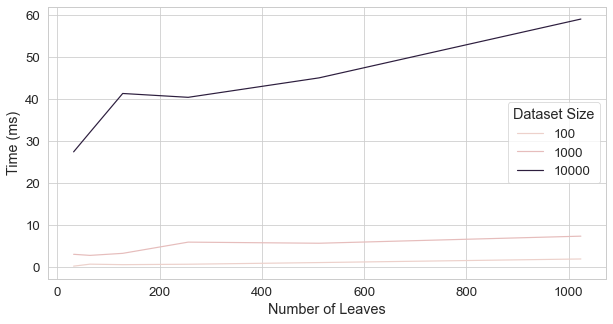

In [13]:
# draw the graph number of leaves vs time as a graph and points
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)
plt.figure(figsize=(10, 5))
ax = sns.lineplot(x="Number of Leaves", y="Time (ms)", hue="Dataset Size", data=df1)



In [6]:
df2

,Total Number of Tree Nodes,Laplacian Noise,Key Generation,Encryption,Tree Generation(Dataset size = 10000),Total Time
0,63,0.000142,0.883105,0.602663,0.027476,1.513387
1,127,0.000210,1.765950,1.221347,0.032124,3.019631
2,255,0.000530,3.640154,2.495387,0.041353,6.177423
3,511,0.001102,7.236615,4.866972,0.040439,12.145129
4,1023,0.001436,15.082199,10.468735,0.045066,25.597437
5,2047,0.003723,31.189803,21.395037,0.059045,52.647607


Finally we capture a, fully unrealistic/worst-case scenario, retrieve the values from all the leaves of a 1024 leaves tree

In [14]:
import time

N = 10

x = np.random.randint(1, 2**N, 10000)
C = Curator(N, x, G=G, P=P)
C.encrypt()
t0 = time.perf_counter()
checksum = sum([C.T.query_interval([i, i]) for i in range(1, 2**N+1)])
if checksum == 10000:
    print("Time to retrieve leaves: ", round(time.perf_counter() - t0, 5), "s", sep="")
else:
    print("Error", time.time() - t0)

Time to retrieve leaves: 0.16545s
